# geodesyNET vs masconCUBE
A geodesyNET is but a new representation of the mass density of an irregular body.

One can see it as a parametrization of a continuous function $\rho(x,y,z)$ whose parameters $\eta_i$ (network weights and biases) are learned efficiently thanks to the SGD approach.

The question arises on how it compares with respect to the state-of-the-art in geodesy techniques. While any comparison to existing methods is bound to be unfair as geodesyNETs are the only representation that can learn the body shape and its interior structure simultaneously, we can introduce an alternative model (we call masconCUBE) that can be compared in fairness to GeodesyNET.

A masconCUBE is a cube full of mascons so that $N\times N\times N$ mascons $m_j$ are placed withing the unit volume $V$ in a regular grid. We may then consider the various masses $m_j$ as the parameters of a model to be learned from observations.

Differently from a geodesyNET, a masconCUBE does not represent the body density continuously, but other than this important detail the two representations have similar properties and hence can be compared once the various parameters $\eta_i$ for the network and $m_i$ for the masconCUBE are learned.

![alt text](figures/masconCUBE.png)

In this notebook we setup the learning procedure for a masconCUBE. Note that the value of the gravitational acceleration created by a masconCUBE at $\mathbf r_i$ is:
$$
\mathbf a_i = \sum_{j=1}^{N^3} \frac {m_j}{r_{ij}^3}{\mathbf r_{ij}}
$$
which means that each measurment of a gravitational acceleration results in linear relation so that at the end putting all measurements together one may write:
$$
\mathbf A \mathbf m = \mathbf b
$$
In most cases, when $N>20$ this system becomes to large to be solved and one must revert to alternative approaches, in particular gradient descent based.

In [1]:
# Import our module containing helper functions
import gravann

# Core imports
import numpy as np
import scipy
import pickle as pk
import os
from collections import deque
import torchquad as tquad
tquad.set_log_level("CRITICAL")
from copy import deepcopy

# pytorch
from torch import nn
import torch

# plotting stuff
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib notebook

# Ensure that changes in imported module (gravann most importantly) are autoreloaded
%load_ext autoreload
%autoreload 2

# If possible enable CUDA
gravann.enableCUDA()
gravann.fixRandomSeeds()
device = os.environ["TORCH_DEVICE"]
print("Will use device ",device)

C:\ProgramData\Miniconda3\envs\geodesynet\lib\site-packages\pyvista\themes.py:123: PyvistaDeprecationWarning: use "dark" instead of "night" theme
  warnings.warn('use "dark" instead of "night" theme', PyvistaDeprecationWarning)
15:36:46|TQ-INFO| Initializing torchquad.


Available devices  1
__pyTorch VERSION: 1.10.0
__CUDNN VERSION: 7605
__Number CUDA Devices: 1
Active CUDA Device: GPU 0
Setting default tensor type to Float32
Will use device  cuda:0


# Loading and visualizing a mascon model
For the purpose of this notebook we will be using, as ground truth, also a mascon model: the one of Eros.
Note though that the procedure in generic and one could also use a polyhedral gravity gound truth or other models.

In [2]:
# We load the ground truth (a mascon model of some body)
with open("mascons/Eros.pk", "rb") as file:
    mascon_points, mascon_masses, mascon_name = pk.load(file)
    
mascon_points = torch.tensor(mascon_points)
mascon_masses = torch.tensor(mascon_masses)

# Print some information on the loaded ground truth 
# (non-dimensional units assumed. All mascon coordinates are thus in -1,1 and the mass is 1)
print("Name: ", mascon_name)
print("Number of mascons: ", len(mascon_points))
print("Total mass: ", sum(mascon_masses))

Name:  Eros
Number of mascons:  39554
Total mass:  tensor(1.0000, dtype=torch.float64)


<IPython.core.display.Javascript object>


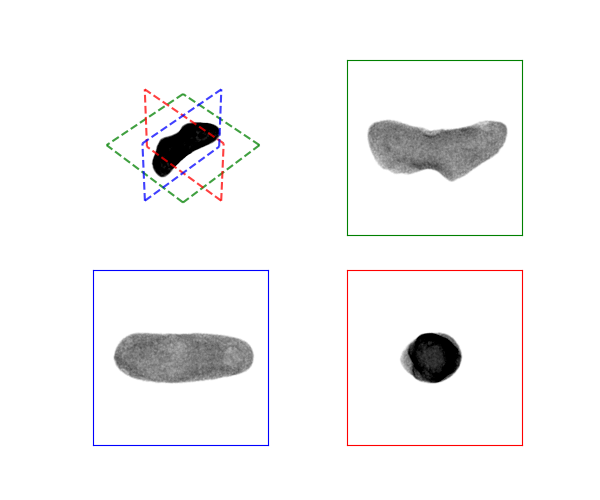

In [3]:
# Here we visualize the loaded ground truth
gravann.plot_mascon(mascon_points, mascon_masses)

# Learning the masconCUBE model


In [7]:
# This is the number of mascons per side of our masconCUBE
N=45
print("MasconCUBE number of parameters is: ", N*N*N)
# Here we define the sqrt(m_j) or model parameters
mascon_masses_model = torch.ones((N*N*N,1), requires_grad=True)
#mascon_masses_model = mascon_masses_model.clone().detach().requires_grad_(True)

MasconCUBE number of parameters is:  91125


In [8]:
# Here we define the points of the masconCUBE
X,Y,Z = torch.meshgrid(torch.linspace(-1,1, N), torch.linspace(-1,1, N), torch.linspace(-1,1, N), indexing='ij')
X = X.reshape(-1,1)
Y = Y.reshape(-1,1)
Z = Z.reshape(-1,1)
mascon_points_model = torch.concat((X,Y,Z), dim=1)

In [9]:
# Dimension of the batch size, i.e. number of points
# where the ground truth is compared to the predicted acceleration
# at each training epoch.
batch_size = 1000

# Loss. The normalized L1 loss. 
loss_fn = gravann.normalized_L1_loss

# The sampling method to decide what points to consider in each batch.
# In this case we sample points unifromly in a sphere and reject those that are inside the asteroid
targets_point_sampler = gravann.get_target_point_sampler(batch_size, 
                                                         limit_shape_to_asteroid="3dmeshes/Eros_lp.pk", 
                                                         method="spherical", 
                                                         bounds=[0,1])

# Here we set the optimizer
learning_rate = 1e-1
optimizer = torch.optim.Adam(params = [mascon_masses_model], lr = learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor = 0.8, patience = 200, min_lr = 1e-8,verbose=True)

# And init the best results
best_loss = np.inf

# When a new network is created we init empty training logs
loss_log = []
weighted_average_log = []
running_loss_log = []
# .. and we init a loss trend indicators
weighted_average = deque([], maxlen=20)

In [10]:
# TRAINING LOOP (normal training, no use of any prior shape information)------------------------
# This cell can be stopped and started again without loosing memory of the training nor its logs
torch.cuda.empty_cache()
# The main training loop
for i in range(5000):
    # Each ten epochs we resample the target points
    if (i % 10 == 0):
        target_points = targets_point_sampler()
        # We compute the labels whenever the target points are changed
        labels = gravann.ACC_L(target_points, mascon_points, mascon_masses)
    
    # We compute the values predicted by the neural density field
    predicted = gravann.ACC_L(target_points, mascon_points_model, mascon_masses_model*mascon_masses_model)
    
    # We compute the scaling constant (k in the paper) used in the loss
    c = torch.sum(predicted*labels)/torch.sum(predicted*predicted)
    
    # We compute the loss
    loss = loss_fn(predicted.view(-1), labels.view(-1))
    
    # We store the model if it has the lowest fitness 
    # (this is to avoid losing good results during a run that goes wild)
    if loss < best_loss:
        best_model = deepcopy(mascon_masses_model)
        best_loss = loss
        print('New Best: ', loss.item())
    
    # Update the loss trend indicators
    weighted_average.append(loss.item())
    
    # Update the logs
    weighted_average_log.append(np.mean(weighted_average))
    loss_log.append(loss.item())
    
    # Print every i iterations
    if i % 25 == 0:
        wa_out = np.mean(weighted_average)
        print(f"It={i}\t loss={loss.item():.3e}\t  weighted_average={wa_out:.3e}\t  c={c:.3e}")
        
    # Zeroes the gradient (necessary because of things)
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()
    
    # Perform a step in LR scheduler to update LR
    scheduler.step(loss.item())

New Best:  0.6994993686676025
It=0	 loss=6.995e-01	  weighted_average=6.995e-01	  c=1.226e-05
New Best:  0.5653504729270935
New Best:  0.4712732434272766
New Best:  0.43299925327301025
New Best:  0.41020292043685913
New Best:  0.3870905041694641
New Best:  0.36300551891326904
New Best:  0.33887726068496704
New Best:  0.3152298033237457
New Best:  0.2926616966724396
New Best:  0.28134483098983765
New Best:  0.2611218988895416
New Best:  0.24168908596038818
New Best:  0.2228797972202301
New Best:  0.2061510980129242
New Best:  0.19097554683685303
New Best:  0.1774798184633255
New Best:  0.16567657887935638
New Best:  0.15520751476287842
New Best:  0.1459750533103943
New Best:  0.14459943771362305
New Best:  0.1368701010942459
New Best:  0.12939290702342987
New Best:  0.12229179590940475
It=25	 loss=1.223e-01	  weighted_average=2.102e-01	  c=1.513e-05
New Best:  0.11559068411588669
New Best:  0.10931002348661423
New Best:  0.10317782312631607
New Best:  0.09726514667272568
New Best:  0.09

It=1475	 loss=1.635e-03	  weighted_average=1.271e-03	  c=2.981e-06
It=1500	 loss=1.191e-03	  weighted_average=1.284e-03	  c=2.977e-06
It=1525	 loss=1.106e-03	  weighted_average=1.168e-03	  c=2.978e-06
It=1550	 loss=8.108e-04	  weighted_average=9.550e-04	  c=2.977e-06
It=1575	 loss=7.413e-04	  weighted_average=7.531e-04	  c=2.976e-06
It=1600	 loss=1.229e-03	  weighted_average=7.731e-04	  c=2.976e-06
Epoch  1621: reducing learning rate of group 0 to 4.0960e-02.
New Best:  0.0005322149954736233
It=1625	 loss=5.322e-04	  weighted_average=7.683e-04	  c=2.974e-06
New Best:  0.0005132686928845942
New Best:  0.00045911510824225843
It=1650	 loss=1.797e-03	  weighted_average=1.102e-03	  c=2.976e-06
It=1675	 loss=1.116e-03	  weighted_average=1.277e-03	  c=2.974e-06
It=1700	 loss=1.681e-03	  weighted_average=9.562e-04	  c=2.977e-06
It=1725	 loss=4.925e-03	  weighted_average=2.698e-03	  c=2.960e-06
It=1750	 loss=1.218e-03	  weighted_average=1.129e-03	  c=2.966e-06
It=1775	 loss=7.269e-04	  weighted

It=4100	 loss=1.296e-03	  weighted_average=5.535e-04	  c=2.947e-06
It=4125	 loss=6.697e-04	  weighted_average=1.078e-03	  c=2.946e-06
It=4150	 loss=8.190e-04	  weighted_average=6.054e-04	  c=2.945e-06
It=4175	 loss=8.282e-04	  weighted_average=6.291e-04	  c=2.946e-06
It=4200	 loss=1.231e-03	  weighted_average=8.033e-04	  c=2.944e-06
It=4225	 loss=6.902e-04	  weighted_average=9.689e-04	  c=2.946e-06
Epoch  4232: reducing learning rate of group 0 to 2.8147e-03.
It=4250	 loss=1.334e-03	  weighted_average=1.031e-03	  c=2.944e-06
It=4275	 loss=3.754e-04	  weighted_average=5.866e-04	  c=2.946e-06
It=4300	 loss=7.761e-04	  weighted_average=1.025e-03	  c=2.944e-06
It=4325	 loss=8.360e-04	  weighted_average=8.097e-04	  c=2.945e-06
It=4350	 loss=6.099e-04	  weighted_average=6.841e-04	  c=2.946e-06
It=4375	 loss=2.127e-03	  weighted_average=1.293e-03	  c=2.941e-06
It=4400	 loss=1.244e-03	  weighted_average=8.417e-04	  c=2.945e-06
It=4425	 loss=7.924e-04	  weighted_average=8.878e-04	  c=2.946e-06


<IPython.core.display.Javascript object>


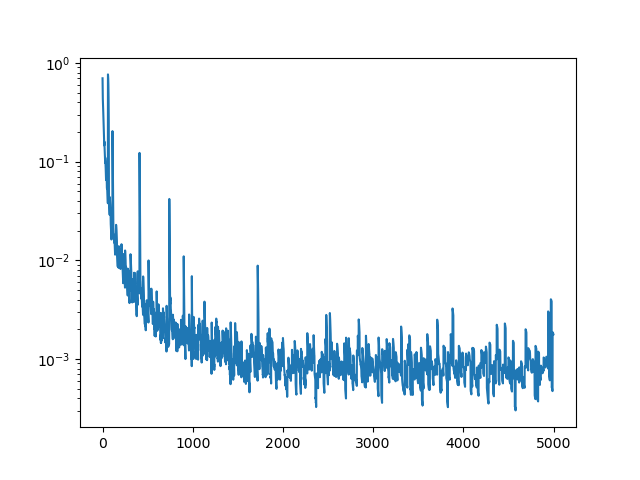

In [12]:
plt.figure()
plt.semilogy(loss_log)

In [13]:
# The actual value of the mascon masses is here obtained by squaring and normalizing
final_mascon_masses = best_model*best_model/torch.sum(best_model*best_model)

In [14]:
# Units of Length (this is Eros) (depend on how the the mascon model was created .... )
# These numbers matter for the final values quantitatively (but not qualitatively)
L  = 20413.864850997925
R0 = 16000/L

In [15]:
# Let us generate all Stokes coefficients up to order 7 and degree 7 (a square model)
l=7
m=7
stokesC_mascon, stokesS_mascon = gravann.mascon2stokes(mascon_points_model.cpu().numpy(), final_mascon_masses.view(-1).detach().cpu().numpy(), R0, l, m)

<IPython.core.display.Javascript object>


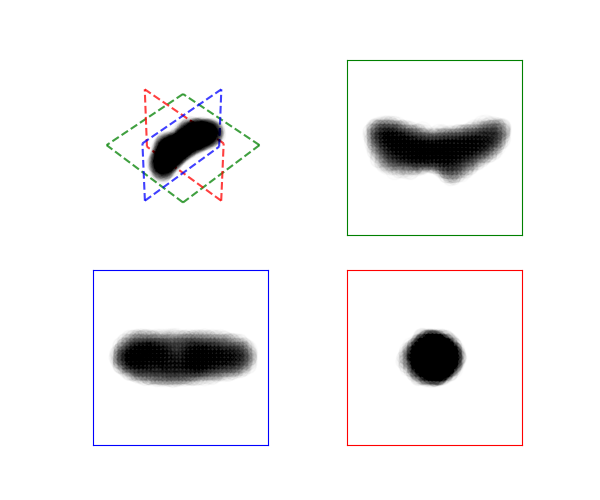

In [16]:
# Here we first trim the small values (for visualization purposes)
final_mascon_masses[final_mascon_masses<1e-5] = 0
# Then we plot
gravann.plot_mascon(mascon_points_model, final_mascon_masses.detach())

# Quantitative comparison with ground truth and geodestNET

In [17]:
with open("stokes/stokes_77_eros_gt.pk", "rb") as file:
    stokesC_gt, stokesS_gt = pk.load(file)
with open("stokes/stokes_77_eros_gann.pk", "rb") as file:
    stokesC_gann, stokesS_gann = pk.load(file)

In [18]:
# Here we compute the sorted indexes corresponding to the largest values
idxs = np.dstack(np.unravel_index(np.argsort(-np.abs(stokesC_gt.ravel())), (8, 8)))[0]
# We print to screen the three models
print(f"Harmonics \tGround Truth \tGeodesyNET \tMasconCUBE")
for pos in idxs:
    l,m = pos
    print(f"C_{l}{m}, \t\t{stokesC_gt[l][m]:2.3e}, \t{stokesC_gann[l][m]:2.3e}, \t{stokesC_mascon[l][m]:2.3e}")

Harmonics 	Ground Truth 	GeodesyNET 	MasconCUBE
C_00, 		1.000e+00, 	1.000e+00, 	1.000e+00
C_22, 		8.766e-02, 	8.772e-02, 	8.765e-02
C_20, 		-5.281e-02, 	-5.289e-02, 	-5.280e-02
C_44, 		1.950e-02, 	1.940e-02, 	1.950e-02
C_42, 		-1.815e-02, 	-1.812e-02, 	-1.817e-02
C_40, 		1.304e-02, 	1.288e-02, 	1.302e-02
C_62, 		6.580e-03, 	6.524e-03, 	6.584e-03
C_64, 		-5.532e-03, 	-5.865e-03, 	-5.516e-03
C_60, 		-4.920e-03, 	-4.844e-03, 	-4.925e-03
C_66, 		4.122e-03, 	4.083e-03, 	4.124e-03
C_31, 		3.385e-03, 	3.369e-03, 	3.381e-03
C_33, 		-3.329e-03, 	-3.340e-03, 	-3.324e-03
C_55, 		-2.620e-03, 	-2.623e-03, 	-2.625e-03
C_51, 		-2.499e-03, 	-2.503e-03, 	-2.491e-03
C_53, 		2.339e-03, 	2.329e-03, 	2.367e-03
C_32, 		1.910e-03, 	1.920e-03, 	1.914e-03
C_71, 		1.660e-03, 	1.669e-03, 	1.672e-03
C_73, 		-1.459e-03, 	-1.487e-03, 	-1.438e-03
C_30, 		-1.427e-03, 	-1.452e-03, 	-1.423e-03
C_75, 		1.111e-03, 	1.164e-03, 	1.046e-03
C_52, 		-9.079e-04, 	-9.130e-04, 	-9.004e-04
C_54, 		8.065e-04, 	6.823e-04, 	8.181e-0